# Validating PReSto2k

## Author
[Tanaya Gondhalekar](https://orcid.org/0009-0004-2440-3266)

For this notebook, we will be following a similar formula as the [_Validating a Reconstruction_](https://linked.earth/reproduce_lmr_pb/notebooks/validation/C03_a_validation.html) Notebook. The goal is to evaluate the skill of the "PReSto2k" reconstructions, produced by adding records from [Iso2k](https://pastglobalchanges.org/science/wg/2k-network/projects/iso2k/intro), and [CoralHydro2k](https://pastglobalchanges.org/science/wg/2k-network/projects/coral-hydro/intro) to the [PAGES2k](https://pastglobalchanges.org/science/wg/2k-network/Phase_2_Databases/Global_Temp/V2.0.0_2017) compilation. Our baseline for the various comparisons are to [LMRv2.1](https://doi.org/10.5194/cp-15-1251-2019), which used only PAGES 2k records, specifically those from wood, coral and glacier ice archives with annual or better resolution.  Specifically, we seek to quantify improvements/changes made as part of the [_PReSto_](https://paleopresto.com/#:~:text=Presto%20is%20the%20Paleoclimate%20Reconstruction,our%20understanding%20of%20past%20climate.)  project. 

In [1]:
%load_ext autoreload
%autoreload 2

import cfr
import numpy as np
print(cfr.__version__)
import pens
import xarray as xr
import pandas as pd
import pickle

# Plotting helpers  
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from typing import List, Dict

2025.7.28


## Load the Reconstructions

Within PReSto2k, we have three separate reconstructions:
- PReSto2k with class-based seasonality
- PReSto2k with metadata-based seasonality
- PReSto2k with metadata-based seasonality and interpolation 

We will compare them against the base reconstruction of LMRv2.1 [Tardif et al. 2019](https://cp.copernicus.org/articles/15/1251/2019/).

In [2]:
# Load class-based

res = cfr.ReconRes('./recons/lmr_reproduce_lipd/')
res.load(['tas', 'tas_gm'])

In [3]:
# Load meta-based

res1 = cfr.ReconRes('./recons/presto2k_season/')
res1.load(['tas', 'tas_gm'])

In [4]:
# Load meta-based with interpolation

res2 = cfr.ReconRes('./recons/presto2k_season_interp/')
res2.load(['tas', 'tas_gm'])

In [5]:
res_ts = res.recons['tas_gm']
res1_ts = res1.recons['tas_gm']
res2_ts = res2.recons['tas_gm']

In [10]:
# Load LMRv2.1 (offline DA) 

lmr_off = xr.open_dataset('./prev_data/gmt_MCruns_ensemble_full_LMRv2.1.nc')
ens_values = lmr_off.gmt.stack(ensemble=['MCrun', 'members']).values  # Shape: (time, MCrun*members)
time_values = lmr_off.time.values
years = np.array([t.year for t in time_values])
lmr_ens = cfr.EnsTS(time=years, value=ens_values, value_name='Temperature Anomaly (°C)')

## GMST plots

We first plot the GMST ensembles for all four reconstructions. This is mainly to see if we can identify any striking differences and check if the variability appears similar or different within each of the reconstructions. Another thing we can check just with our eyes is to see if there is any variation in how each of the reconstructions captured extreme climate events. 

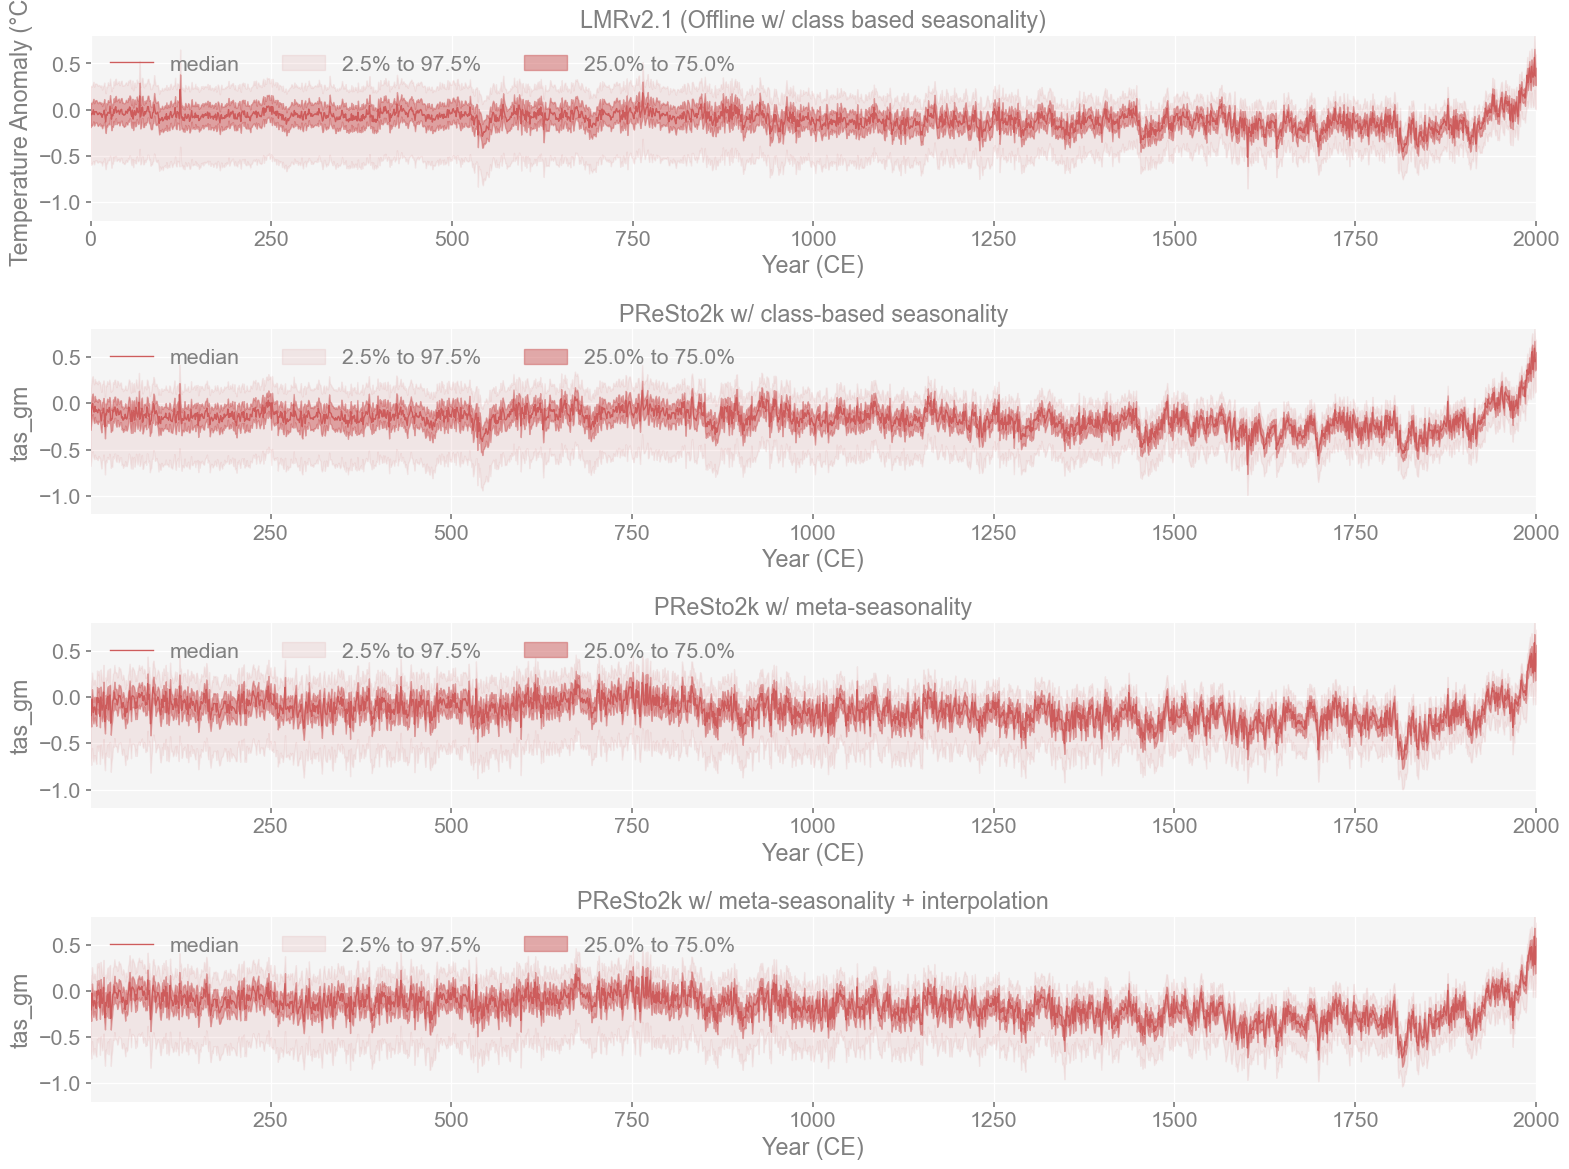

In [8]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(16, 12))

lmr_ens.plot_qs(ax=ax1, ylim=[-1.2, 0.8])
ax1.set_title('LMRv2.1 (Offline w/ class based seasonality)')

res_ts.plot_qs(ax=ax2, ylim=[-1.2, 0.8])
ax2.set_title('PReSto2k w/ class-based seasonality')

res1_ts.plot_qs(ax=ax3, ylim=[-1.2, 0.8])
ax3.set_title('PReSto2k w/ meta-seasonality')

res2_ts.plot_qs(ax=ax4, ylim=[-1.2, 0.8]) 
ax4.set_title('PReSto2k w/ meta-seasonality + interpolation')

plt.tight_layout()
plt.show()

Upon first glance, all four reconstructions look very similar. Though you can notice that in LMRv2.1 and PReSto2k with class-based seasonality, there are more significant dips in temperature around 550 CE. In contrast, in the metadata-based reconstructions, there appears to be greater cooling around 1800 CE, which is not captured by the first two. We can examine this segment further to see if it coincides with the Tambora Eruption (1815). 

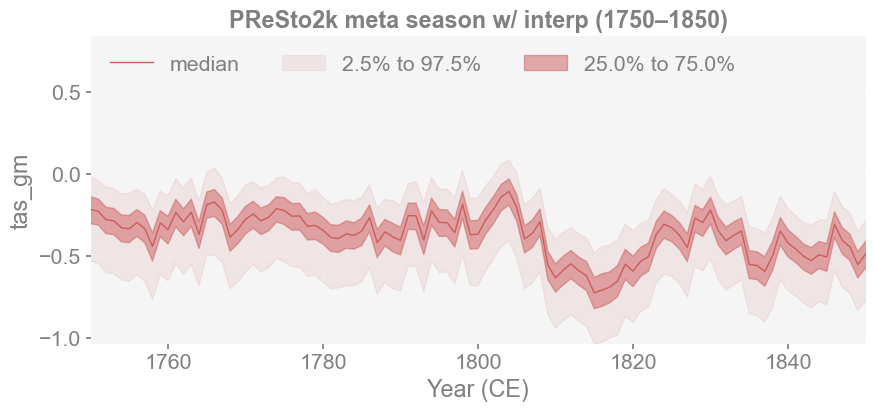

In [15]:
fig, ax = plt.subplots(figsize=(10,4))
res2_ts.plot_qs(ax=ax, xlim=(1750, 1850), title='PReSto2k meta season w/ interp (1750–1850)')
ax.grid(True, alpha=0.3)

In [24]:
median_ts = res2_ts.median        
imin = np.nanargmin(median_ts)
t_min_median = res2_ts.time[imin]
v_min_median = median_ts[imin]
print(f"Minimum: {v_min_median:.3f} at year {t_min_median:.1f}")


Minimum: -0.725 at year 1815.0


(<Figure size 1000x800 with 2 Axes>, <GeoAxes: title={'center': 'tas, 1815'}>)

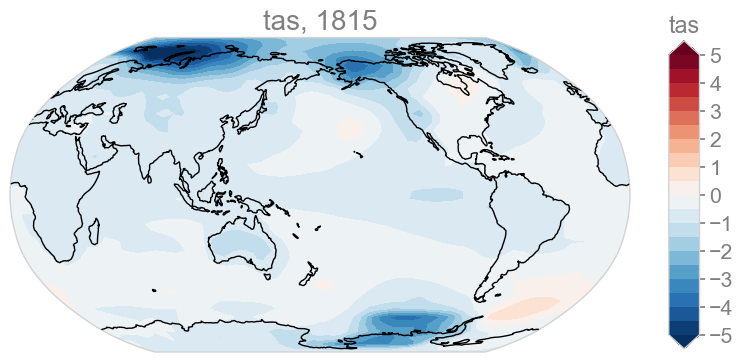

In [44]:
# Looking at the spatial patterns of this minimum year

res1.recons['tas']['1815'].plot(
        levels=np.linspace(-5, 5, 21),      
        cbar_labels=np.linspace(-5, 5, 11),  
)

### Difference Plots

Since we cannot tell (accurately) how similar or different reconstructions are at a glace, a difference plot of their ensemble mean can be a good way to identify specific instances where one reconstruction captures greater warming/cooling over another. Within this, instead of comparing each reconstruction to another, I thought it would be important to reduce it down to three main comparisons.
- PReSto2k class-based vs. LMRv2.1 
- PReSto2k meta-based vs. LMRv2.1 
- PReSto2k meta-based vs. class-based 

For comparison purposes, both metadata based seasonality approaches are treated as mostly the same. In a subsequent section (instrumental validation), we will see that the added interpolation tends to improve the reconstruction ever so slightly, but that can be added to these validation methods later on if we see fit. 

In [8]:
# Compute the ensemble means

lmr_ens_mean = np.mean(lmr_ens.value, axis=1)
res_ts_mean = np.mean(res_ts.value, axis=1)
res1_ts_mean = np.mean(res1_ts.value, axis=1)

# Use the minimum length for everything
min_len = min(len(lmr_ens_mean), len(res_ts_mean))
difference = res_ts_mean[:min_len] - lmr_ens_mean[:min_len] 
difference2 = res1_ts_mean[:min_len] - lmr_ens_mean[:min_len]
difference3 = res1_ts_mean[:min_len] - res_ts_mean[:min_len] 

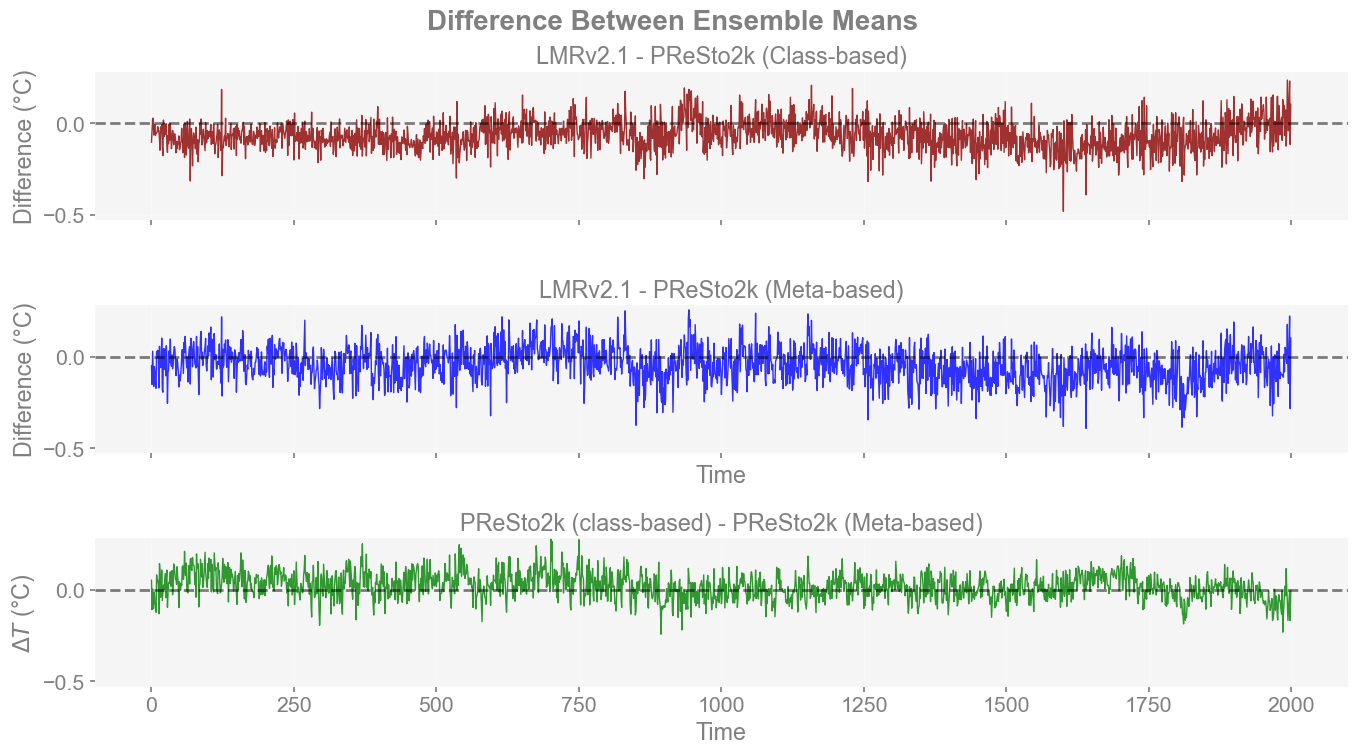

In [9]:
# Find common y-axis limits
y_min = min(np.min(difference), np.min(difference2)) * 1.1
y_max = max(np.max(difference), np.max(difference2)) * 1.1

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 8), sharex=True, sharey=True)

# Top plot: Class-based difference
ax1.plot(lmr_ens.time[:min_len], difference, color='darkred', linewidth=1, alpha=0.8)
ax1.axhline(y=0, color='k', linestyle='--', alpha=0.5)
ax1.set_ylabel('Difference (°C)')
ax1.set_title('LMRv2.1 - PReSto2k (Class-based)')
ax1.grid(True, alpha=0.3)
ax1.set_ylim(y_min, y_max)

# Bottom plot: Meta-based difference
ax2.plot(lmr_ens.time[:min_len], difference2, color='blue', linewidth=1, alpha=0.8)
ax2.axhline(y=0, color='k', linestyle='--', alpha=0.5)
ax2.set_ylabel('Difference (°C)')
ax2.set_xlabel('Time')
ax2.set_title('LMRv2.1 - PReSto2k (Meta-based)')
ax2.grid(True, alpha=0.3)
ax2.set_ylim(y_min, y_max)

# Bottom plot: Meta-based difference
ax3.plot(lmr_ens.time[:min_len], difference3, color='green', linewidth=1, alpha=0.8)
ax3.axhline(y=0, color='k', linestyle='--', alpha=0.5)
ax3.set_ylabel(r'$\Delta T$ (°C)')
ax3.set_xlabel('Time')
ax3.set_title('PReSto2k (class-based) - PReSto2k (Meta-based)')
ax3.grid(True, alpha=0.3)
ax3.set_ylim(y_min, y_max)

plt.suptitle('Difference Between Ensemble Means', fontsize=20, y=0.95, fontweight='bold')
plt.tight_layout()
plt.show()

Using these difference plots, it is immediately more noticeable that there are some spots (notably around 850 CE) where LMRv2.1 does not capture as great a cooling as either PReSto 2k reconstruction. It is also apparent that the differences between class-based and expert seasonality appear to be much smaller than compared to LMRv2.1. It is also clear that class-based seasonality predicts cooler overall temperature anomalies than compilation metadata (expert-based) before 1000 CE. 

## Pens
As done in _Validating a Reconstruction_, we will use the plume framework introduced by [Emile-Geay et al. (2025)](https://journals.ametsoc.org/view/journals/clim/38/5/JCLI-D-24-0101.1.xml) using the _pens_ package. To summarize again, this framework compares collections of climate trajectories (plumes) by evaluating:

- Intra-ensemble distances, which describe the spread of trajectories within an ensemble.

- Inter-ensemble distances, which measure differences between two ensembles.

- The plume distance, a summary metric (°C) that captures the degree of similarity (or dissimilarity) between two plumes while accounting for internal variability.

We compute these distances using the GMST ensembles from the original LMRv2.1 and our PReSto2k reconstructions. All are converted into `pens.EnsembleTS` objects for ease of comparison.

**Note**: The closer the plume distance is to zero, the more similar the ensembles are.


In [12]:
import pens
import seaborn as sns

plt.style.use('default')
pens.set_style()

In [13]:
# Function for ease of plotting multiple comparisons

def plot_pens(ts1, ts1_name, ts2, ts2_name):
    # Convert cfr EnsTS to pens EnsTS
    ts1_pens = pens.EnsembleTS(time=ts1.time, value=ts1.value)
    ts1_pens.label = 'Original LMR'
    ts1_pens.time_unit = 'years'
    ts1_pens.value_name = 'GMST'
    ts1_pens.value_unit = '\N{DEGREE SIGN}C'

    ts2_pens = pens.EnsembleTS(time=ts2.time, value=ts2.value)
    ts2_pens.label = 'PReSto2k-offlineDA'
    ts2_pens.time_unit = 'years'
    ts2_pens.value_name = 'GMST'
    ts2_pens.value_unit = '\N{DEGREE SIGN}C'

    # Align time dimension for both EnsTS

    ts1_time = ts1.time
    ts2_time = ts2.time.values

    common_start = max(ts1_time.min(), ts2_time.min())
    common_end = min(ts1_time.max(), ts2_time.max())

    # Create time range array
    timespan = np.array([common_start, common_end])

    # Slice to common period
    ts1_pens_aligned = ts1_pens.slice(timespan)
    ts2_pens_aligned = ts2_pens.slice(timespan)

    # Calculate stats 
    ts1_intra = ts1_pens_aligned.distance()
    ts2_intra = ts2_pens_aligned.distance()

    # Calculate inter-ensemble distance 
    inter_dist = ts1_pens_aligned.distance(ts2_pens_aligned.value)
        
    # Calculate plume distance 
    plume_dist = ts1_pens_aligned.plume_distance(ts2_pens_aligned.value, max_dist=1.0)

    print("\nDistances between ensembles:")
    print(f"Original intra-ensemble distance : {ts1_intra},\ len={len(ts1_intra)}", )
    print(f"Reproduced intra-ensemble distance: {ts2_intra},\ len={len(ts2_intra)}")
    print(f"Inter-ensemble distance: {inter_dist}")
    print(f"Plume distance: {plume_dist}")


    # Create figure and plot
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot KDE for individual ensembles with explicit labels
    sns.kdeplot(data=ts1_intra, fill=False, ax=ax, common_norm=False, label=ts1_name)
    sns.kdeplot(data=ts2_intra, fill=False, ax=ax, common_norm=False, label=ts2_name)

    # Add inter-ensemble distribution
    sns.kdeplot(data=inter_dist, fill=True, ax=ax, common_norm=False, color='silver', 
                label='inter-ensemble')

    # Add plume distance line
    ax.axvline(x=plume_dist, color="black", linestyle="--", label='plume distance')

    # Axis + ticks
    ax.set_xlim(0, 1)
    ax.set_xticks(np.arange(0, 1.05, 0.05))
    ax.minorticks_on()
    ax.grid(True, which='both', alpha=0.25, linestyle='--', linewidth=0.6)


    # Add labels
    ax.set_xlabel('Distance')
    ax.set_ylabel('Density')
    ax.set_title('Distance Distributions')
    ax.legend()

    plt.tight_layout()
    plt.show()

Computing intra-ensemble distance among possible pairs: 100%|██████████| 1999000/1999000 [00:42<00:00, 47494.24it/s]
Computing intra-ensemble distance among possible pairs: 100%|██████████| 12497500/12497500 [03:58<00:00, 52481.32it/s]
Computing inter-ensemble distance: 100%|██████████| 2000/2000 [03:29<00:00,  9.53it/s]



Distances between ensembles:
Original intra-ensemble distance : [0.40367679 0.21343417 0.04743079 ... 0.26221506 0.05118074 0.29547632],\ len=1999000
Reproduced intra-ensemble distance: [1.0092546  0.17004128 0.33781567 ... 0.19607017 0.12532675 0.07074343],\ len=12497500
Inter-ensemble distance: [0.31925129 0.6902534  0.15575017 ... 0.21786565 0.41357816 0.34283473]
Plume distance: 0.15510274440047797


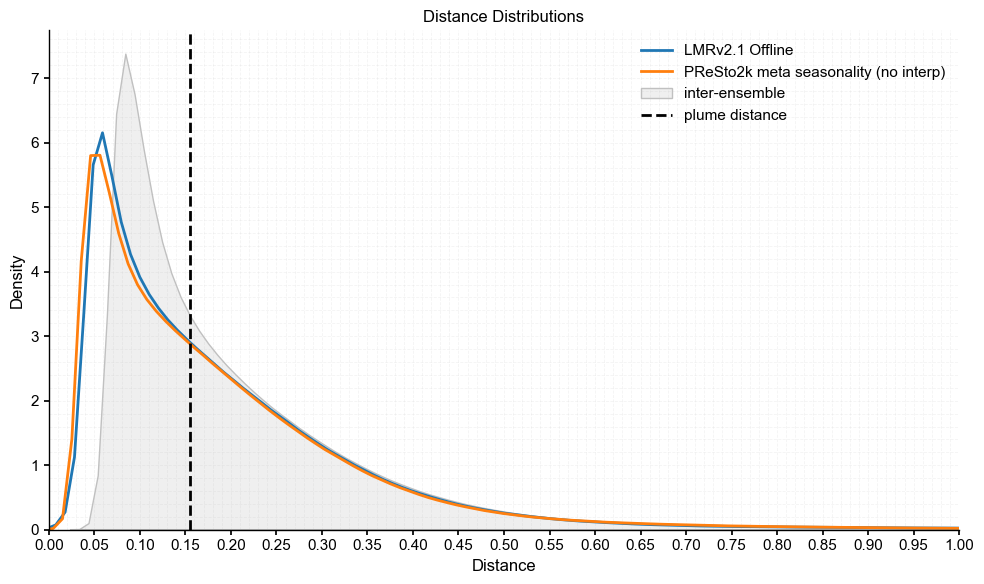

In [14]:
plot_pens(lmr_ens, 'LMRv2.1 Offline', res1_ts, 'PReSto2k meta seasonality (no interp)')

Computing intra-ensemble distance among possible pairs: 100%|██████████| 1999000/1999000 [00:42<00:00, 46933.43it/s]
Computing intra-ensemble distance among possible pairs: 100%|██████████| 12497500/12497500 [04:01<00:00, 51812.75it/s]
Computing inter-ensemble distance: 100%|██████████| 2000/2000 [03:31<00:00,  9.44it/s]



Distances between ensembles:
Original intra-ensemble distance : [0.40367679 0.21343417 0.04743079 ... 0.26221506 0.05118074 0.29547632],\ len=1999000
Reproduced intra-ensemble distance: [0.91594323 0.13586752 0.2780244  ... 0.2092932  0.15233736 0.05700134],\ len=12497500
Inter-ensemble distance: [0.26008597 0.65616499 0.13131738 ... 0.2464135  0.45569422 0.39873838]
Plume distance: 0.15399506737029178


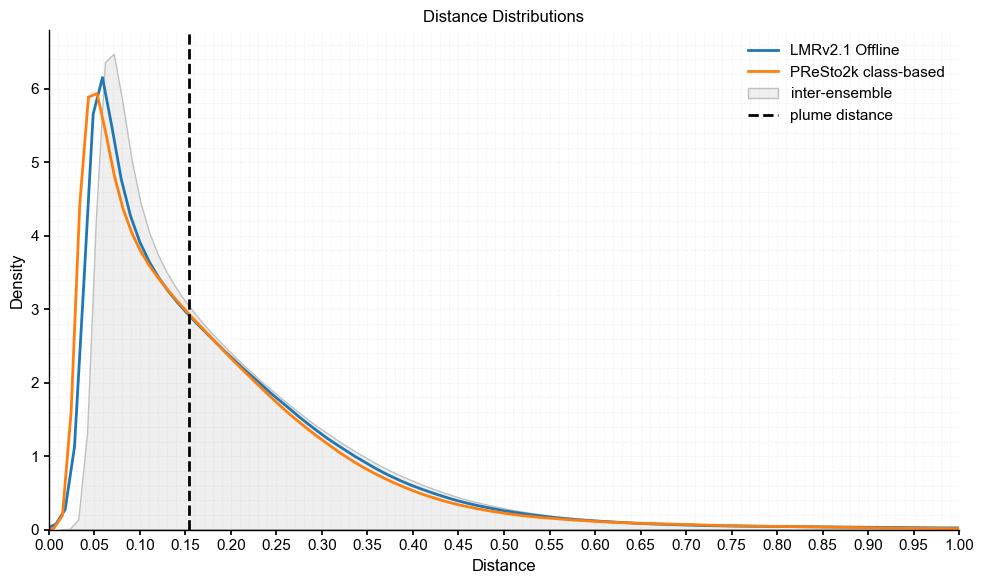

In [31]:
plot_pens(lmr_ens, 'LMRv2.1 Offline', res_ts, 'PReSto2k class-based')

Computing intra-ensemble distance among possible pairs: 100%|██████████| 12497500/12497500 [04:00<00:00, 51859.78it/s]
Computing intra-ensemble distance among possible pairs: 100%|██████████| 12497500/12497500 [04:00<00:00, 51873.87it/s]
Computing inter-ensemble distance: 100%|██████████| 5000/5000 [07:54<00:00, 10.55it/s]



Distances between ensembles:
Original intra-ensemble distance : [0.91594323 0.13586752 0.2780244  ... 0.2092932  0.15233736 0.05700134],\ len=12497500
Reproduced intra-ensemble distance: [1.00691248 0.16223658 0.33689253 ... 0.19224536 0.12171932 0.07052603],\ len=12497500
Inter-ensemble distance: [0.08145034 0.95276477 0.11608722 ... 0.15290283 0.07001891 0.0692549 ]
Plume distance: 0.14609708156212153


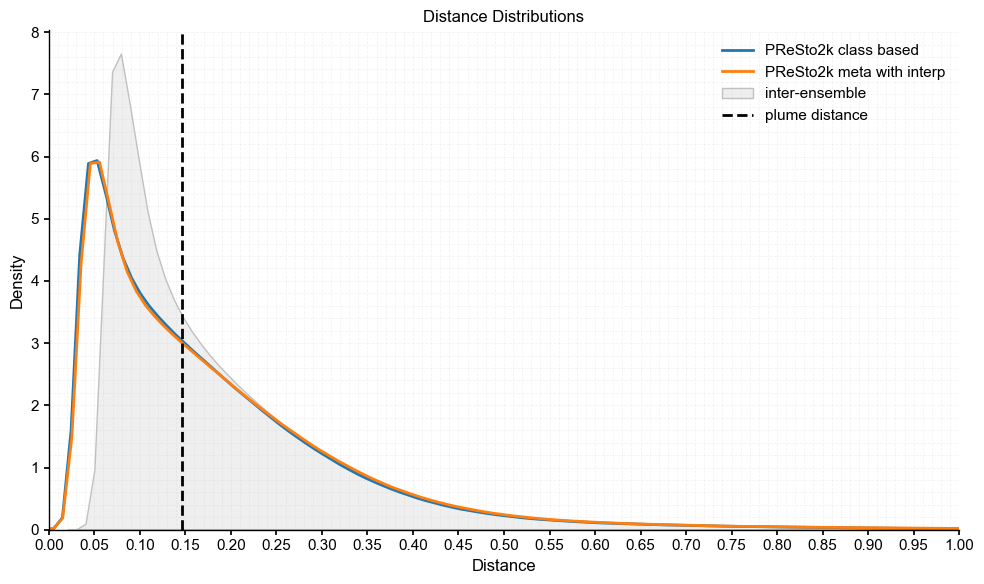

In [32]:
plot_pens(res_ts, 'PReSto2k class based', res2_ts, 'PReSto2k meta with interp')

As we see here, all three of the comparisons have plume distances ~0.15 °C, which is not negligible but still within range of the inter-ensemble spread. The smallest distance is between the PReSto2k metadata and class-based versions, which we also noted earlier in the difference plots as being most similar. Importantly, all plume distances fall within the spread of intra-ensemble variability and closely track the original distribution, indicating that the reconstructions are statistically compatible and not significantly different from each other. 

## Instrumental Validation

While comparing against other reconstructions is important, we can only establish skill by comparising against instrumental (and independent) data. We will validate our PReSto2k reconstructions' GMST against the original LMRv2.1 (offline) and some instrumental datasets (HadCRUT5, BEST, GISTEMP). These datasets were used to validate the original LMRv2.1 back in 2019; here we will be using the most updated versions of the datasets. 

_cfr_’s `EnsTS.compare()` will take the ensemble time series and the plot the median and the spread of our original dataset and plot it against the target, or validation, dataset.

The following function uses built-in `cfr` functionality to compare two GMST time series and returns the comparison data array as well as the validation statistics ($r$, $CE$). 

To save space and for the reason of not making this step convoluted, we have opted out of making comparison plots for all the validations (3 instrumental data sets x 4 reconstructions... a lot). Instead, the validation statistics from this function will be output in a table at the end of the section. 

In [15]:
def plot_ensts_compare(target_ts, target_name, ts, ts_name, timespan = (1880,2000)):
    compared = ts.compare(
    target_ts, 
    ref_name=target_name , 
    timespan= timespan
    )

    corr = compared.valid_stats['corr']
    CE = compared.valid_stats['CE']

    #fig, ax = compared.plot_qs(figsize=[12, 4], xlim=[1880,2000], title= f'{ts_name} v {target_name}')

    return compared, corr, CE

### GMST comparisons
#### GISTEMP

The first dataset we will use to validate is [GISTEMP](https://data.giss.nasa.gov/gistemp/news/2010summer/). Note that GISTEMPv4 is instrumental data, but it is not independent as it was used to calibrate our proxy system models. Given this, we expect the corr and CE for all reconstructions to be especially high for this dataset. 

In [16]:
gis = xr.load_dataset('./analyses/GISTEMP/gistemp1200_ERSSTv4.nc')
gis.head()

<xarray.Dataset>
Dimensions:      (lat: 5, lon: 5, time: 5, nv: 2)
Coordinates:
  * lat          (lat) float32 -89.0 -87.0 -85.0 -83.0 -81.0
  * lon          (lon) float32 -179.0 -177.0 -175.0 -173.0 -171.0
  * time         (time) datetime64[ns] 1880-01-15 1880-02-15 ... 1880-05-15
Dimensions without coordinates: nv
Data variables:
    time_bnds    (time, nv) datetime64[ns] 1880-01-01 1880-02-01 ... 1880-06-01
    tempanomaly  (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
Attributes:
    title:        GISTEMP Surface Temperature Analysis
    institution:  NASA Goddard Institute for Space Studies
    source:       http://data.giss.nasa.gov/gistemp/
    Conventions:  CF-1.6
    history:      Created 2017-05-12 10:40:20 by SBBX_to_nc 2.0 - ILAND=1200,...

In [ ]:
# Area weights ~ cos(lat)
weights = np.cos(np.deg2rad(gis['lat']))

# Weighted mean over space
gm = gis.tempanomaly.weighted(weights).mean(dim=['lat', 'lon'])

gis_annual = gm.groupby('time.year').mean()

# Make sure values are properly shaped ([,:1])
gis_values = gis_annual.values
if gis_values.ndim == 1:
    gis_values = gis_values[:, np.newaxis] 

# annualize GISTEMP
gis_ts_annual = cfr.EnsTS(
    time=gis_annual.year.values,
    value=gis_values,
    value_name='Temperature Anomaly'
)

In [ ]:
gis_res, gis_rescor, gis_resce = plot_ensts_compare(gis_ts_annual, 'GISTEMPv4', res_ts, 'PReSto2k class-based')
gis_res1, gis_res1cor, gis_res1ce = plot_ensts_compare(gis_ts_annual, 'GISTEMPv4', res1_ts, 'PReSto2k meta season')
gis_res2, gis_res2cor, gis_res2ce = plot_ensts_compare(gis_ts_annual, 'GISTEMPv4', res2_ts, 'PReSto2k meta season w/ interp')
gis_lmr, gis_lmrcor, gis_lmrce = plot_ensts_compare(gis_ts_annual, 'GISTEMPv4', lmr_ens, 'LMRv2.1')

#### HADCRUT5

Same process as before, but this time we use [HadCRUT5](https://www.metoffice.gov.uk/hadobs/hadcrut5/). LMRv2.1 used HADCRUT4 for their validations, but we are using the most updated dataset, since it exists. This time we load the dataset from the cloud, then convert the dataframe to a `cfr.EnsTS` object. 


In [19]:
url = 'https://www.metoffice.gov.uk/hadobs/hadcrut5/data/HadCRUT.5.0.2.0/analysis/diagnostics/HadCRUT.5.0.2.0.analysis.summary_series.global.annual.csv'
df = pd.read_csv(url)
df.head()

,Time,Anomaly (deg C),Lower confidence limit (2.5%),Upper confidence limit (97.5%)
0,1850,-0.417711,-0.589256,-0.246166
1,1851,-0.233350,-0.411868,-0.054832
2,1852,-0.229399,-0.409382,-0.049416
3,1853,-0.270354,-0.430009,-0.110700
4,1854,-0.291521,-0.432712,-0.150330


In [21]:
had_ts_annual = cfr.EnsTS().from_df(df=df,time_column='Time', value_columns='Anomaly (deg C)')

In [ ]:
had_res, had_rescor, had_resce = plot_ensts_compare(had_ts_annual, 'HADCRUT5', res_ts, 'PReSto2k class-based')
had_res1, had_res1cor, had_res1ce = plot_ensts_compare(had_ts_annual, 'HADCRUT5', res1_ts, 'PReSto2k meta season')
had_res2, had_res2cor, had_res2ce = plot_ensts_compare(had_ts_annual, 'HADCRUT5', res2_ts, 'PReSto2k meta season w/ interp')
had_lmr, had_lmrcor, had_lmrce = plot_ensts_compare(had_ts_annual, 'HADCRUT5', lmr_ens, 'LMRv2.1')

#### Berkeley Earth Surface Temperature (BEST)

Same process as before, but for [BEST](https://berkeleyearth.org/data/). We will also use BEST for our climate field validations later.

In [23]:
best = xr.load_dataset('./analyses/BerkeleyEarth/Land_and_Ocean_LatLong1.nc')
best

<xarray.Dataset>
Dimensions:      (longitude: 360, latitude: 180, time: 1980, month_number: 12)
Coordinates:
  * longitude    (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * latitude     (latitude) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * time         (time) float64 1.85e+03 1.85e+03 ... 2.015e+03 2.015e+03
Dimensions without coordinates: month_number
Data variables:
    land_mask    (latitude, longitude) float64 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0
    temperature  (time, latitude, longitude) float32 nan nan ... 0.4631 0.4641
    climatology  (month_number, latitude, longitude) float32 -28.21 ... -31.3
Attributes:
    Conventions:           Berkeley Earth Internal Convention (based on CF-1.5)
    title:                 Native Format Berkeley Earth Surface Temperature A...
    history:               17-Feb-2015 11:17:51
    institution:           Berkeley Earth Surface Temperature Project
    land_source_history:   16-Jan-2015 09:30:27
    ocean_source_history:  08-Jan-2015 06:07:03
    comment:               This file contains Berkeley Earth surface temperat...

In [24]:

# Define weights (area ∝ cos(lat))
weights = np.cos(np.deg2rad(best['latitude']))

# Area-weighted global mean
gm = best['temperature'].weighted(weights).mean(dim=['latitude', 'longitude'])

# Convert time coordinate to datetime index (specific to BEST)
time_index = pd.date_range(start='1850-01-01', periods=len(best.time), freq='M')
gm = gm.assign_coords(time=time_index)

best_annual = gm.groupby('time.year').mean()

# Reshape values if needed
best_values = best_annual.values
if best_values.ndim == 1:
    best_values = best_values[:, np.newaxis]

# annualize
best_ts_annual = cfr.EnsTS(
    time=best_annual.year.values,
    value=best_values,
    value_name='Temperature Anomaly'
)


In [ ]:
best_res, best_rescor, best_resce = plot_ensts_compare(best_ts_annual, 'BEST', res_ts, 'PReSto2k class-based')
best_res1, best_res1cor, best_res1ce = plot_ensts_compare(best_ts_annual, 'BEST', res1_ts, 'PReSto2k meta season')
best_res2, best_res2cor, best_res2ce = plot_ensts_compare(best_ts_annual, 'BEST', res2_ts, 'PReSto2k meta season w/ interp')
best_lmr, best_lmrcor, best_lmrce = plot_ensts_compare(best_ts_annual, 'BEST', lmr_ens, 'LMRv2.1')

#### Consensus

In addition to the individual validation analyses, we can now plot them all together along with a ‘consensus’ time series, which is the mean of all the instrumental datasets.

In [27]:
# combine all datasets to calculate mean (class based)
all_refs = np.array([
   had_res.ref_value[:121],
   gis_res.ref_value[:121],
   best_res.ref_value[:121]
])
mean_ref = np.mean(all_refs, axis=0)

mean_ts_annual = cfr.EnsTS(
    time=best_annual.year.values[30:-14], #manually slice dates
    value=mean_ref,
    value_name='Temperature Anomaly'
)

mean_ts_compared = res_ts.compare(
    mean_ts_annual,
    ref_name='Consensus',
    timespan=(1880, 2000)
)

# combine all datasets to calculate mean (no interp)
all_refs1 = np.array([
   had_res1.ref_value[:121],
   gis_res1.ref_value[:121],
   best_res1.ref_value[:121]
])
mean_ref1 = np.mean(all_refs1, axis=0)

mean_ts1_annual = cfr.EnsTS(
    time=best_annual.year.values[30:-14], #manually slice dates
    value=mean_ref1,
    value_name='Temperature Anomaly'
)

mean_ts1_compared = res1_ts.compare(
    mean_ts1_annual,
    ref_name='Consensus',
    timespan=(1880, 2000)
)

# combine all datasets to calculate mean (with interp)
all_refs2 = np.array([
   had_res2.ref_value[:121],
   gis_res2.ref_value[:121],
   best_res2.ref_value[:121]
])
mean_ref2 = np.mean(all_refs2, axis=0)

mean_ts2_annual = cfr.EnsTS(
    time=best_annual.year.values[30:-14], #manually slice dates
    value=mean_ref2,
    value_name='Temperature Anomaly'
)

mean_ts2_compared = res2_ts.compare(
    mean_ts2_annual,
    ref_name='Consensus',
    timespan=(1880, 2000)
)

# combine all datasets to calculate mean (LMR)
all_refsl = np.array([
   had_lmr.ref_value[:121],
   gis_lmr.ref_value[:121],
   best_lmr.ref_value[:121]
])
mean_refl = np.mean(all_refsl, axis=0)

mean_tsl_annual = cfr.EnsTS(
    time=best_annual.year.values[30:-14], #manually slice dates
    value=mean_refl,
    value_name='Temperature Anomaly'
)

mean_tsl_compared = lmr_ens.compare(
    mean_tsl_annual,
    ref_name='Consensus',
    timespan=(1880, 2000)
)

In [30]:
results_table_data = {
    'HadCRUT5': [had_rescor, had_res1cor, had_res2cor, had_lmrcor,
                 had_resce, had_res1ce, had_res2ce, had_lmrce],
    'GISTEMP': [gis_rescor, gis_res1cor, gis_res2cor, gis_lmrcor,
                gis_resce, gis_res1ce, gis_res2ce, gis_lmrce],
    'Berkeley Earth': [best_rescor, best_res1cor, best_res2cor, best_lmrcor,
                       best_resce, best_res1ce, best_res2ce, best_lmrce],
    'Consensus': [mean_ts_compared.valid_stats['corr'], mean_ts1_compared.valid_stats['corr'], mean_ts2_compared.valid_stats['corr'], mean_tsl_compared.valid_stats['corr'],
                  mean_ts_compared.valid_stats['CE'], mean_ts1_compared.valid_stats['CE'], mean_ts2_compared.valid_stats['CE'], mean_tsl_compared.valid_stats['CE']]
}

# Create multi-level index
index_tuples = [
    ('PReSto2k class-based', 'R'),
    ('PReSto2k meta season', 'R'), 
    ('PReSto2k meta season w/ interp', 'R'),
    ('LMRv2.1', 'R'),
    ('PReSto2k class-based', 'CE'),
    ('PReSto2k meta season', 'CE'),
    ('PReSto2k meta season w/ interp', 'CE'),
    ('LMRv2.1', 'CE')
]

multi_index = pd.MultiIndex.from_tuples(index_tuples, names=['Reconstruction', 'Metric'])

results_df = pd.DataFrame(results_table_data, index=multi_index)

print("COMPLETE RESULTS TABLE:")
print("=" * 60)
print(results_df.round(3))

COMPLETE RESULTS TABLE:
                                       HadCRUT5  GISTEMP  Berkeley Earth  \
Reconstruction                 Metric                                      
PReSto2k class-based           R          0.928    0.919           0.917   
PReSto2k meta season           R          0.874    0.874           0.857   
PReSto2k meta season w/ interp R          0.891    0.889           0.877   
LMRv2.1                        R          0.933    0.932           0.921   
PReSto2k class-based           CE         0.608    0.827           0.744   
PReSto2k meta season           CE         0.612    0.765           0.698   
PReSto2k meta season w/ interp CE         0.659    0.787           0.739   
LMRv2.1                        CE         0.565    0.834           0.719   

                                       Consensus  
Reconstruction                 Metric             
PReSto2k class-based           R           0.927  
PReSto2k meta season           R           0.874  
PReSto2k me

#### Takeaways from the Results Table

**Correlations (R)**
- LMRv2.1 is still the strongest overall, clearly better than all PReSto2k variants.
- PReSto2k class-based comes very close to LMR (~ within 0.01–0.02 in most cases).
- PReSto2k meta-seasonality lags somewhat, while meta w/ interpolation is marginally better.

**Coefficient of Efficiency (CE)**
- PReSto2k class-based outperform LMRv2.1 in all cases.
- Meta seasonality is weakest, but interpolation boosts it, and ends up being the best in terms of the consensus.
- LMRv2.1 is middle of the road, but usually a bit lower than PReSto2k class-based or interpolated meta-based.

**Overall**
- LMRv2.1 remains the standard in terms of correlation with observational data.
- PReSto2k class-based nearly matches LMR’s correlations while showing better CE scores, which could imply improved predictive skill.
- Meta seasonality with interpolation can match or exceed class-based in CE, but both meta-based reconstructions are still worse in correlation.

So, PReSto2k reconstructions can safely rival (and sometimes surpass) LMRv2.1 in skill, depending on the metric, especially when class-based or meta-seasonality with interpolation are used.

> NOTE: These instrumental validations are only done from 1880-2000, which means its still missing a very large portion of the picture. Namely 1-1880, which misses the medieval climate anomaly, Little Ice Age, and many large volcanic events. There are also probably biases in validation due to the more recent proxy/instrumental overlaps, where data quality and density is higher.

### Validation on Climate Fields

Load in both BEST climate field and the original LMR air (2m air temperature) climate field as `cfr.ClimateField` objects and modify the format so that we can more easily compare it with our validation datasets using _cfr_. In this step, we will plot both the correlation (corr) and the coefficient of efficiency (CE) of 2m air temperature against the Berkeley Earth Surface Temperature (BEST) climate field, since that was what Tardif et al. (2019) used to validate their field reconstructions.

#### BEST

In [6]:
ds = xr.open_dataset('./analyses/BerkeleyEarth/Land_and_Ocean_LatLong1.nc')

# Convert decimal years to datetime
years = ds.time.values
dates = pd.to_datetime([f"{int(year)}-{int((year % 1) * 12 + 1):02d}-15" for year in years])

# Create a new DataArray with proper coordinates
da = xr.DataArray(
    ds.temperature.values,
    coords={
        'time': dates,
        'lat': ds.latitude.values,
        'lon': ds.longitude.values
    },
    dims=['time', 'lat', 'lon'],
    name='temperature'
)

# 3. create ClimateField object
target_be = cfr.ClimateField(da).get_anom(ref_period=[1951, 1980])
target_be = target_be.annualize(months=list(range(1,13)))
target_be.da

# Convert target data to 0-360 format first
target_wrapped = target_be.wrap_lon(mode='360')

In [7]:
lmr_tas = cfr.ClimateField().load_nc(
    path='./prev_data/air_MCruns_ensemble_mean_LMRv2.1.nc',
    vn='air', 
    time_name='time',  
    lat_name='lat', 
    lon_name='lon'
)

target_lmr = lmr_tas.get_anom(ref_period=[1951, 1980])
filtered_da = target_lmr.da.sel(time=target_lmr.da.time.dt.year != 0)
target_lmr = cfr.ClimateField(da=filtered_da)
target_lmr = target_lmr.annualize(months=list(range(1,13)))

target_lmr_mean = cfr.ClimateField(da=target_lmr.da.mean(dim='MCrun'))


In [19]:
# Function to get the comparison statistics from a climate field compare 

def get_cf_stat(target_cf, target_name, cf, cf_name, stat, ax=None):
    valid_fdb = cf.compare(
        target_cf,
        stat=stat,
        timespan=(1880, 2000),
        interp_target = 'ref',
    )

    return valid_fdb

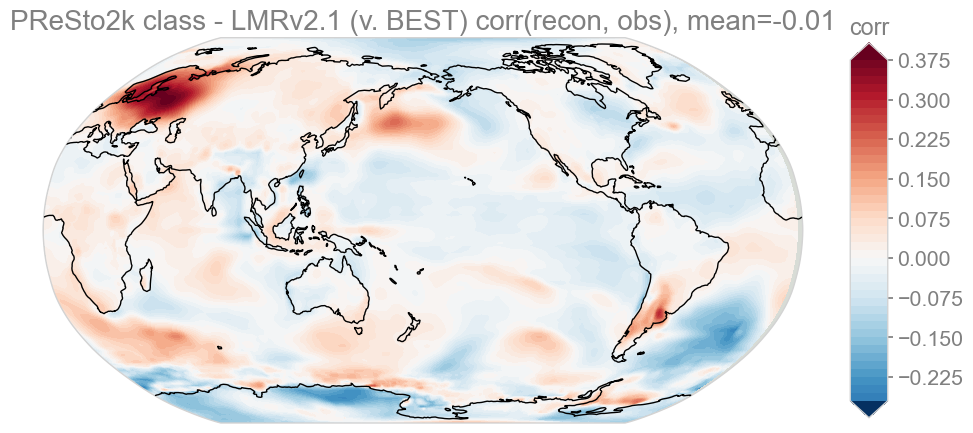

In [20]:
lmrvbest = get_cf_stat(target_wrapped, 'BEST', target_lmr_mean, 'LMRv2.1', stat='corr')
p2kclassvbest = get_cf_stat(target_wrapped, 'BEST', res.recons['tas'], 'PReSto2k class based', stat='corr')

diff = p2kclassvbest - lmrvbest

# compute symmetric color scale
vmax = np.nanmax(np.abs(diff.da.values))
clim = (-vmax, vmax)

diff.plot(
    title=f'PReSto2k class - LMRv2.1 (v. BEST) corr(recon, obs), mean={diff.geo_mean().value[0,0]:.2f}',
    plot_cbar=True,
    cmap='RdBu_r',
    clim=clim   # enforce centered colormap
)

plt.tight_layout()
plt.show()

> KEY: Red -- PReSto2k class better than LMRv2.1, Blue -- LMRv2.1 better than PReSto2k class


Here we see that the correlation between LMRv2.1 v Best and PReSto2k v BEST averages out at about 0.0. The stark difference here is that it appears PReSto2k class-based performs much better over Scandinavia and slightly worse in Antarctica. 

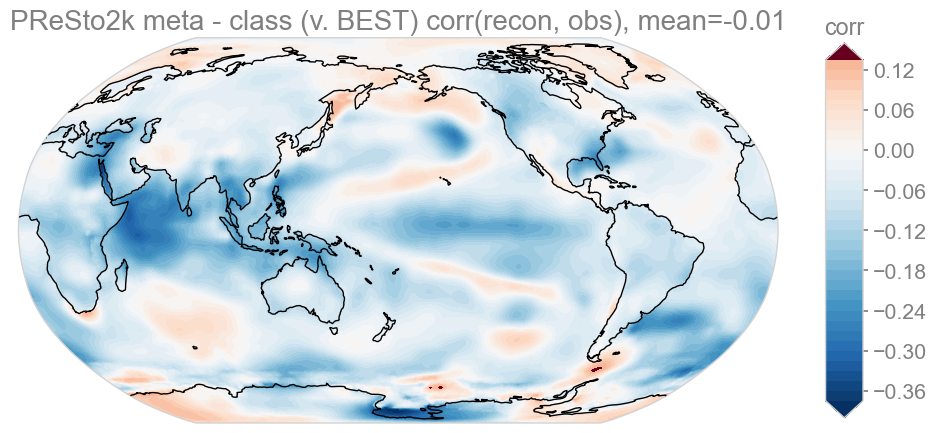

In [21]:
p2kclassvbest = get_cf_stat(target_wrapped, 'BEST', res.recons['tas'], 'PReSto2k class based', stat='corr')
p2kmetaintvbest = get_cf_stat(target_wrapped, 'BEST', res2.recons['tas'], 'PReSto2k meta-season w/ interp', stat='corr')

diff2 = p2kmetaintvbest - p2kclassvbest 

# compute symmetric color scale
vmax = np.nanmax(np.abs(diff2.da.values))
clim = (-vmax, vmax)

diff2.plot(
    title=f'PReSto2k meta - class (v. BEST) corr(recon, obs), mean={diff.geo_mean().value[0,0]:.2f}',
    plot_cbar=True,
    cmap='RdBu_r',
    clim=clim   # enforce centered colormap
)

plt.tight_layout()
plt.show()

> KEY: Red -- meta better than class, Blue -- class better than meta

While global average skill is similar, class-based seasonality outperforms meta-based across much of the Indian, Pacific and Southern Hemisphere oceans, whereas meta shows slight advantages in regions like the North Atlantic, Pacific Cold Tongue, and Antarctica. Overall  this analysis suggests that little is gained by using expert seasonality, as far as PReSto2k reconstructions go.

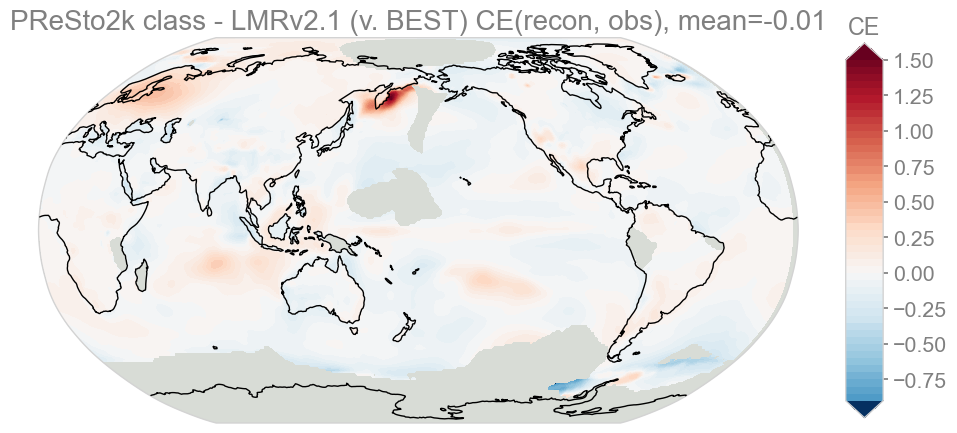

In [22]:
lmrvbest = get_cf_stat(target_wrapped, 'BEST', target_lmr_mean, 'LMRv2.1', stat='CE')
p2kclassvbest = get_cf_stat(target_wrapped, 'BEST', res.recons['tas'], 'PReSto2k class based', stat='CE')

diff = p2kclassvbest - lmrvbest 

# compute symmetric color scale
vmax = np.nanmax(np.abs(diff.da.values))
clim = (-vmax, vmax)

diff.plot(
    title=f'PReSto2k class - LMRv2.1 (v. BEST) CE(recon, obs), mean={diff.geo_mean().value[0,0]:.2f}',
    plot_cbar=True,
    cmap='RdBu_r',
    clim=clim   # enforce centered colormap
)

plt.tight_layout()
plt.show()

> KEY: Red -- class better than LMRv2.1, Blue -- LMRv2.1 better than class

Aside from masked-out gray regions (an upcoming fix), PReSto2k class-based and LMRv2.1 have nearly identical CE skill overall, with  minor regional differences (class-based doing slightly better over Scandinavia, while LMR has very small advantages in scattered locations along the North Atlantic and Austrialia).

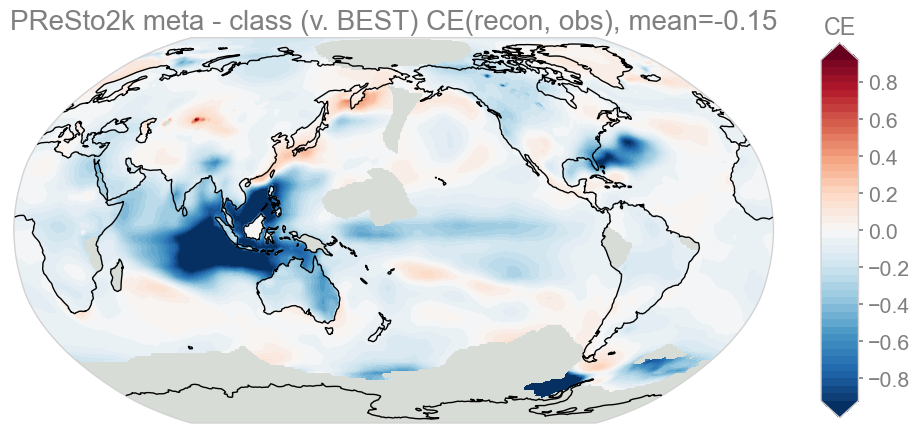

In [23]:
p2kclassvbest = get_cf_stat(target_wrapped, 'BEST', res.recons['tas'], 'PReSto2k class based', stat='CE')
p2kmetaintvbest = get_cf_stat(target_wrapped, 'BEST', res2.recons['tas'], 'PReSto2k meta-season w/ interp', stat='CE')

diff2 =  p2kmetaintvbest - p2kclassvbest

vmax = np.nanpercentile(np.abs(diff2.da.values), 98)
clim = (-vmax, vmax)

# clip just for plotting
vals = diff2.da.values.copy()
vals = np.clip(vals, -vmax, vmax)

diff2_clipped = diff2.copy()
diff2_clipped.da.values = vals

diff2_clipped.plot(
    title=f'PReSto2k meta - class (v. BEST) CE(recon, obs), mean={diff2.geo_mean().value[0,0]:.2f}',
    plot_cbar=True,
    cmap='RdBu_r',
    clim=clim
)

plt.tight_layout()
plt.show()

> KEY: Red -- meta better than class, Blue -- class better than meta
> 
It is apparent for this one that class-based seasonality performs significantly better over southeast asia and parts of the North Atlantic (Caribbean region). Everywhere else is pretty even in terms of skill.

## PSM Calibration Statistics

One way to understand these results is to examine the calibration scores of the proxy system models (PSMs). Here we compare two seasonality approaches used by our PReSto2k reconstructions:
- Class-based: seasonalities are broadly defined for each proxy class.
- Metadata-based: each proxy record uses an expert-designated seasonality defined in its metadata.

These choices directly affect how the PSMs are calibrated within the data assimilation workflow (see: _Run Data Assimilation with Individual Seasonality_).

A well-calibrated proxy record is characterized by its PSM successfully explaining a significant portion of observed climate variability during the calibration period, typically reflected in a strong fit metric like R^2. This aligns with how PSMs are used in paleoclimate DA, where calibration makes sure that the proxy accurately reflects the climate signal and drives confidence in reconstruction results. 

In this section, we compile calibration statistics and examine the spatial distribution of records with high R^2 values. This provides insight into the regional skill of the climate field reconstruction, beyond what we can infer from just GMST and instrumental validation.


### Load Proxy Databases

These proxy databases should have the post-calibration statsistics saved in their metadata for easier validation.

In [45]:
with open('./prev_data/calibrated/calibrated_lipd_pdb.pkl', 'rb') as f:
    pdb_class_new = pickle.load(f)

job_class_new = cfr.ReconJob()
job_class_new.proxydb = pdb_class_new

In [46]:

with open('./prev_data/calibrated/calibrated_pdb_w_seasonality_annual.pkl', 'rb') as f:
    pdb_meta = pickle.load(f)

job_meta = cfr.ReconJob()
job_meta.proxydb = pdb_meta

with open('./prev_data/calibrated/calibrated_pdb_w_seasonality_annual_interp.pkl', 'rb') as f:
    pdb_meta_interp = pickle.load(f)

job_meta_interp = cfr.ReconJob()
job_meta_interp.proxydb = pdb_meta_interp

In [4]:
# Extract calibration statistics from all three databases
def extract_calib_stats(job, approach_name):
    """Extract PSM calibration statistics from a ReconJob"""
    calib_stats = []
    
    print(f"Collecting PSM calibration statistics for {approach_name}...")
    for pid, record in job.proxydb.records.items():
        if (hasattr(record, 'psm') and record.psm is not None and 
            hasattr(record.psm, 'calib_details') and record.psm.calib_details is not None):
            
            details = record.psm.calib_details
            calib_stats.append({
                'pid': pid,
                'name': record.tags.get('name', 'Unknown') if isinstance(record.tags, dict) else pid,
                'r2_adj': details['fitR2adj'],
                'nobs': details['nobs'],
                'mse': details['PSMmse'],
                'snr': details['SNR'],
                'seasonality': details['seasonality'],
                'approach': approach_name
            })
    
    print(f"Found {len(calib_stats)} calibrated PSMs for {approach_name}")
    return calib_stats

In [5]:
# Extract stats from all three approaches
stats_class = extract_calib_stats(job_class_new, "Class-based seasonality")
stats_meta = extract_calib_stats(job_meta, "Metadata seasonality") 
stats_meta_interp = extract_calib_stats(job_meta_interp, "Metadata + interpolation")

# Combine all stats
all_stats =  stats_class + stats_meta + stats_meta_interp

Found 555 calibrated PSMs for Class-based seasonality
Found 501 calibrated PSMs for Metadata seasonality
Found 522 calibrated PSMs for Metadata + interpolation


### Make Plots

We will have a histogram showing the distribution of the R^2 values, a summary table with statistics, and a spatial distribution with locations of well-calibrated records (threshold can be adjusted). 

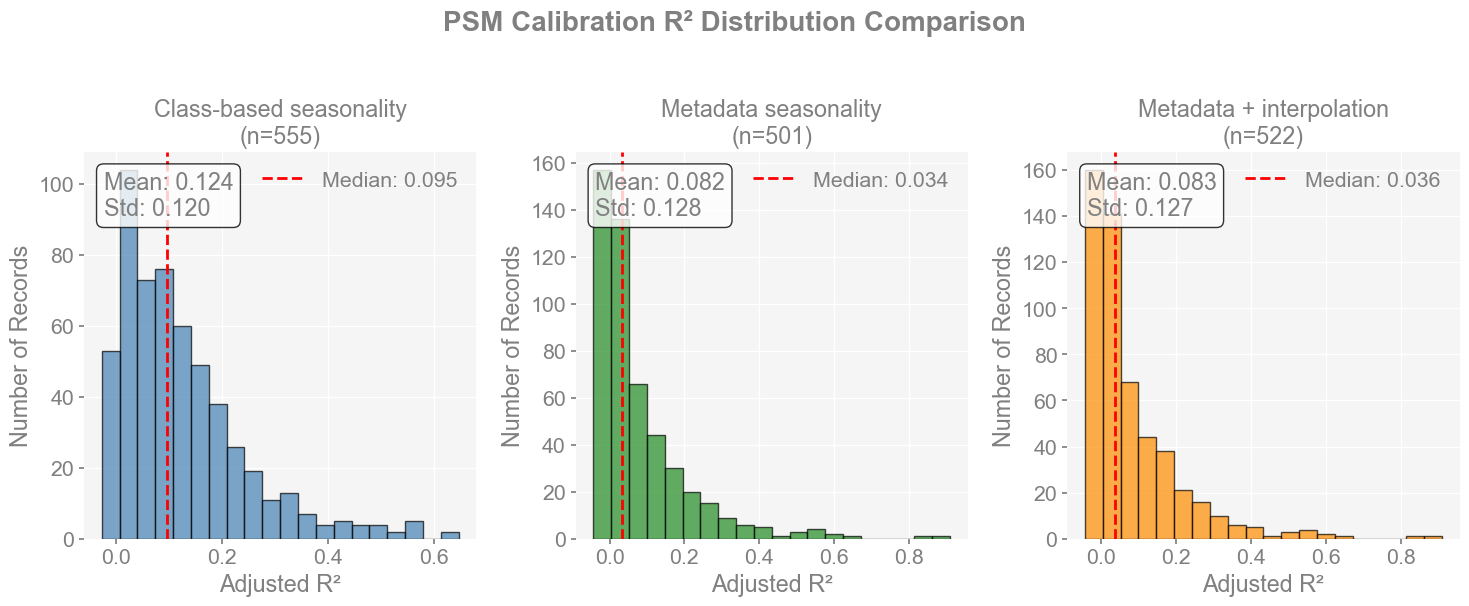

In [6]:
# Create comparison plot
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
fig.suptitle('PSM Calibration R² Distribution Comparison', fontsize=20, y=1.02, fontweight="bold")

approaches = ["Class-based seasonality", "Metadata seasonality", "Metadata + interpolation"]
colors = ['steelblue', 'forestgreen', 'darkorange']

for i, (approach, color) in enumerate(zip(approaches, colors)):
    # Get R² values for this approach
    approach_stats = [stat for stat in all_stats if stat['approach'] == approach]
    r2_values = [stat['r2_adj'] for stat in approach_stats]
    
    # Plot histogram
    axes[i].hist(r2_values, bins=20, alpha=0.7, edgecolor='black', color=color)
    axes[i].set_xlabel('Adjusted R²')
    axes[i].set_ylabel('Number of Records')
    axes[i].set_title(f'{approach}\n(n={len(r2_values)})')
    
    # Add median line
    median_r2 = np.median(r2_values)
    axes[i].axvline(median_r2, color='red', linestyle='--', linewidth=2, 
                   label=f'Median: {median_r2:.3f}')
    axes[i].legend()
    
    # Add summary stats as text
    mean_r2 = np.mean(r2_values)
    std_r2 = np.std(r2_values)
    axes[i].text(0.05, 0.95, f'Mean: {mean_r2:.3f}\nStd: {std_r2:.3f}', 
                transform=axes[i].transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()


In [7]:
# Print summary statistics
print("\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)

for approach in approaches:
    approach_stats = [stat for stat in all_stats if stat['approach'] == approach]
    r2_values = [stat['r2_adj'] for stat in approach_stats]
    
    print(f"\n{approach}:")
    print(f"  Records: {len(r2_values)}")
    print(f"  Mean R²: {np.mean(r2_values):.4f}")
    print(f"  Median R²: {np.median(r2_values):.4f}")
    print(f"  Std R²: {np.std(r2_values):.4f}")
    print(f"  Min R²: {np.min(r2_values):.4f}")
    print(f"  Max R²: {np.max(r2_values):.4f}")
    print(f"  Records with R² > 0.5: {len([r for r in r2_values if r > 0.5])}")
    print(f"  Records with R² > 0.7: {len([r for r in r2_values if r > 0.7])}")



SUMMARY STATISTICS

Class-based seasonality:
  Records: 555
  Mean R²: 0.1242
  Median R²: 0.0949
  Std R²: 0.1205
  Min R²: -0.0277
  Max R²: 0.6473
  Records with R² > 0.5: 13
  Records with R² > 0.7: 0

Metadata seasonality:
  Records: 501
  Mean R²: 0.0815
  Median R²: 0.0345
  Std R²: 0.1279
  Min R²: -0.0433
  Max R²: 0.9098
  Records with R² > 0.5: 11
  Records with R² > 0.7: 2

Metadata + interpolation:
  Records: 522
  Mean R²: 0.0826
  Median R²: 0.0357
  Std R²: 0.1269
  Min R²: -0.0433
  Max R²: 0.9098
  Records with R² > 0.5: 11
  Records with R² > 0.7: 2


In [8]:

PlateCRS = ccrs.PlateCarree()

def _add_base_map(ax):
    ax.add_feature(cfeature.LAND, facecolor="lightgray", alpha=0.5, zorder=0)
    ax.add_feature(cfeature.OCEAN, facecolor="lightblue", alpha=0.5, zorder=0)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.3)
    ax.set_global()


def _prep_xy_r2(stats, r2_key, thr):
    lons, lats, r2s = [], [], []
    for s in stats:
        r2 = s.get(r2_key)
        lon, lat = s.get("lon"), s.get("lat")
        if (r2 is None) or (lon is None) or (lat is None):
            continue
        if r2 > thr:
            lons.append(lon); lats.append(lat); r2s.append(r2)
    return np.asarray(lons), np.asarray(lats), np.asarray(r2s)

def plot_high_r2_spatial_comparison(
    stats_class, stats_meta, stats_meta_interp,
    *, r2_threshold=0.7, figsize=(20, 12), r2_key="r2_adj", cmap="Reds",
    show=False  # <- default False to avoid double display in notebooks
):
    approaches = ("Class-based", "Metadata", "Metadata + interp")
    colors     = ("steelblue", "forestgreen", "darkorange")
    stats_sets = (stats_class, stats_meta, stats_meta_interp)

    xy_r2 = [ _prep_xy_r2(s, r2_key, r2_threshold) for s in stats_sets ]
    counts = [
        int((np.array([d.get(r2_key) for d in s if d.get(r2_key) is not None]) > r2_threshold).sum())
        for s in stats_sets
    ]

    # Figure with a thin bottom row for the colorbar
    fig = plt.figure(figsize=figsize, constrained_layout=False)
    gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 0.06], hspace=0.15, wspace=0.08, figure=fig)

    axes = [
        fig.add_subplot(gs[0, 0], projection=PlateCRS),
        fig.add_subplot(gs[0, 1], projection=PlateCRS),
        fig.add_subplot(gs[1, 0], projection=PlateCRS),
        fig.add_subplot(gs[1, 1], projection=PlateCRS),
    ]
    cax = fig.add_subplot(gs[2, :])  # dedicated colorbar axis

    # Panels 1–3 (colored by R²)
    for ax, name, (lons, lats, r2s), count in zip(axes[:3], approaches, xy_r2, counts):
        _add_base_map(ax)#, with_labels=True)
        if r2s.size:
            ax.scatter(
                lons, lats, c=r2s, cmap=cmap, s=60, alpha=0.8, transform=PlateCRS,
                vmin=r2_threshold, vmax=1.0, edgecolor="black", linewidth=0.5
            )
        ax.set_title(f"{name}\n(n={count} with R² > {r2_threshold:g})", fontsize=11)

    # Panel 4 (combined, colored by approach)
    ax_c = axes[3]
    _add_base_map(ax_c)#, with_labels=True)
    for name, color, (lons, lats, _), count in zip(approaches, colors, xy_r2, counts):
        if lons.size:
            ax_c.scatter(
                lons, lats, c=color, s=40, alpha=0.8, transform=PlateCRS,
                edgecolor="black", linewidth=0.3, label=f"{name} (n={lons.size})"
            )
    ax_c.set_title(f"Combined: R² > {r2_threshold:g}", fontsize=11)
    ax_c.legend(loc="lower left", bbox_to_anchor=(0, 0))

    # Colorbar in its own axis
    norm = Normalize(vmin=r2_threshold, vmax=1.0)
    sm = ScalarMappable(norm=norm, cmap=cmap); sm.set_array([])
    cbar = fig.colorbar(sm, cax=cax, orientation="horizontal")
    cbar.set_label("Adjusted R²")

    fig.suptitle(f"Spatial Distribution of Well-Calibrated PSMs (R² > {r2_threshold:g})", fontsize=16)
    fig.tight_layout(rect=[0, 0.04, 1, 0.98])  # leave a bit for suptitle

    if show:
        plt.show()   # show once if you explicitly ask
        return None  # avoid echoing a Figure
    return fig       # otherwise return the Figure without calling show()


def extract_calib_stats_with_coords(job, approach_name: str, *, r2_key: str = "fitR2adj", verbose: bool = True
                                   ):
    """
    Extract PSM calibration stats incl. coordinates from a ReconJob-like object.

    Expects:
    - job.proxydb.records: mapping of pid -> record
    - record.psm.calib_details: dict containing r², nobs, mse, SNR, seasonality
    - record.lat / record.lon / record.ptype
    - record.tags (dict-like) with optional 'name'
    """
    calib_stats: List[Dict] = []
    if verbose:
        print(f"Collecting PSM calibration statistics for {approach_name}...")

    for pid, record in getattr(job, "proxydb", {}).records.items():
        psm = getattr(record, "psm", None)
        details = getattr(psm, "calib_details", None) if psm is not None else None
        if not details:
            continue

        entry = {
            "pid": pid,
            "name": (record.tags.get("name") if isinstance(record.tags, dict) else None) or pid,
            "r2_adj": details.get(r2_key),           # normalize to 'r2_adj' for plotting
            "nobs": details.get("nobs"),
            "mse": details.get("PSMmse"),
            "snr": details.get("SNR"),
            "seasonality": details.get("seasonality"),
            "approach": approach_name,
            "lat": getattr(record, "lat", None),
            "lon": getattr(record, "lon", None),
            "ptype": getattr(record, "ptype", None),
        }
        calib_stats.append(entry)

    if verbose:
        print(f"Found {len(calib_stats)} calibrated PSMs for {approach_name}")
    return calib_stats

Plotting functions and helpers for spatial distribution. 

In [9]:
# --- CRS (axes + data are both geographic lon/lat) ---
MAP_CRS  = ccrs.PlateCarree()   # for subplot projection
DATA_CRS = ccrs.PlateCarree()   # for the lon/lat data transform

def _add_base_map(ax):
    ax.add_feature(cfeature.LAND, facecolor="lightgray", alpha=0.5, zorder=0)
    ax.add_feature(cfeature.OCEAN, facecolor="lightblue", alpha=0.5, zorder=0)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.3)
    ax.set_global()

def _prep_xy_r2(stats, r2_key, thr):
    """Return lon/lat/r2 arrays filtered by threshold and finite values."""
    lons, lats, r2s = [], [], []
    for s in stats:
        r2 = s.get(r2_key)
        lon, lat = s.get("lon"), s.get("lat")
        if r2 is None or lon is None or lat is None:
            continue
        if r2 > thr:
            lons.append(lon); lats.append(lat); r2s.append(r2)
    if not lons:
        return np.array([]), np.array([]), np.array([])
    lons, lats, r2s = map(np.asarray, (lons, lats, r2s))
    m = np.isfinite(lons) & np.isfinite(lats) & np.isfinite(r2s)
    return lons[m], lats[m], r2s[m]

def plot_high_r2_spatial_comparison(
    stats_class: List[Dict],
    stats_meta: List[Dict],
    stats_meta_interp: List[Dict],
    *,
    r2_threshold: float = 0.2,           # <- lower default so you see points
    figsize=(20, 12),
    r2_key: str = "r2_adj",
    cmap: str = "Reds",
    show: bool = True
):
    approaches = ("Class-based", "Metadata", "Metadata + interp")
    colors     = ("steelblue", "forestgreen", "darkorange")
    stats_sets = (stats_class, stats_meta, stats_meta_interp)

    xy_r2 = [ _prep_xy_r2(s, r2_key, r2_threshold) for s in stats_sets ]
    counts = [
        int((np.array([d.get(r2_key) for d in s if d.get(r2_key) is not None]) > r2_threshold).sum())
        for s in stats_sets
    ]
    # quick sanity print so you know data exist
    print("counts (>= threshold):", [len(x[0]) for x in xy_r2], " | threshold:", r2_threshold)

    # figure with a dedicated colorbar row
    fig = plt.figure(figsize=figsize, constrained_layout=False)
    gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 0.06], hspace=0.15, wspace=0.08, figure=fig)

    axes = [
        fig.add_subplot(gs[0, 0], projection=MAP_CRS),
        fig.add_subplot(gs[0, 1], projection=MAP_CRS),
        fig.add_subplot(gs[1, 0], projection=MAP_CRS),
        fig.add_subplot(gs[1, 1], projection=MAP_CRS),
    ]
    cax = fig.add_subplot(gs[2, :])  # shared colorbar axis

    # panels 1–3 (colored by R²)
    for ax, name, (lons, lats, r2s), count in zip(axes[:3], approaches, xy_r2, counts):
        _add_base_map(ax)
        if r2s.size:
            ax.scatter(
                lons, lats, c=r2s, cmap=cmap, s=60, alpha=0.9,
                transform=DATA_CRS, vmin=r2_threshold, vmax=1.0,
                edgecolor="black", linewidth=0.4
            )
        ax.set_title(f"{name}\n(n={count} with R² > {r2_threshold:g})", fontsize=11)

    # combined panel (colored by approach)
    ax_c = axes[3]
    _add_base_map(ax_c)
    for name, color, (lons, lats, _), _count in zip(approaches, colors, xy_r2, counts):
        if lons.size:
            ax_c.scatter(
                lons, lats, c=color, s=42, alpha=0.9, transform=DATA_CRS,
                edgecolor="black", linewidth=0.3, label=f"{name} (n={lons.size})"
            )
    ax_c.set_title(f"Combined: R² > {r2_threshold:g}", fontsize=11)
    ax_c.legend(loc="lower left", bbox_to_anchor=(0, 0))

    # shared colorbar
    norm = Normalize(vmin=r2_threshold, vmax=1.0)
    sm = ScalarMappable(norm=norm, cmap=cmap); sm.set_array([])
    cbar = fig.colorbar(sm, cax=cax, orientation="horizontal")
    cbar.set_label("Adjusted R²")

    fig.suptitle(f"Spatial Distribution of Well-Calibrated PSMs (R² > {r2_threshold:g})", fontsize=16)
    fig.tight_layout(rect=[0, 0.05, 1, 0.98])

    if show:
        plt.show()
        return None
    return fig

# ---- stats extractor (with coords) ----
def extract_calib_stats_with_coords(job, approach_name: str, *, r2_key: str = "fitR2adj", verbose: bool = True):
    """Extract PSM calibration stats incl. lat/lon."""
    calib_stats: List[Dict] = []
    if verbose:
        print(f"Collecting PSM calibration statistics for {approach_name}...")
    for pid, record in getattr(job, "proxydb", {}).records.items():
        psm = getattr(record, "psm", None)
        details = getattr(psm, "calib_details", None) if psm is not None else None
        if not details:
            continue
        calib_stats.append({
            "pid": pid,
            "name": (record.tags.get("name") if isinstance(record.tags, dict) else None) or pid,
            "r2_adj": details.get(r2_key),
            "nobs": details.get("nobs"),
            "mse": details.get("PSMmse"),
            "snr": details.get("SNR"),
            "seasonality": details.get("seasonality"),
            "approach": approach_name,
            "lat": getattr(record, "lat", None),
            "lon": getattr(record, "lon", None),
            "ptype": getattr(record, "ptype", None),
        })
    if verbose:
        print(f"Found {len(calib_stats)} calibrated PSMs for {approach_name}")
    return calib_stats


Found 555 calibrated PSMs for Class-based
Found 501 calibrated PSMs for Metadata
Found 522 calibrated PSMs for Metadata + interp
counts (>= threshold): [107, 63, 65]  | threshold: 0.2


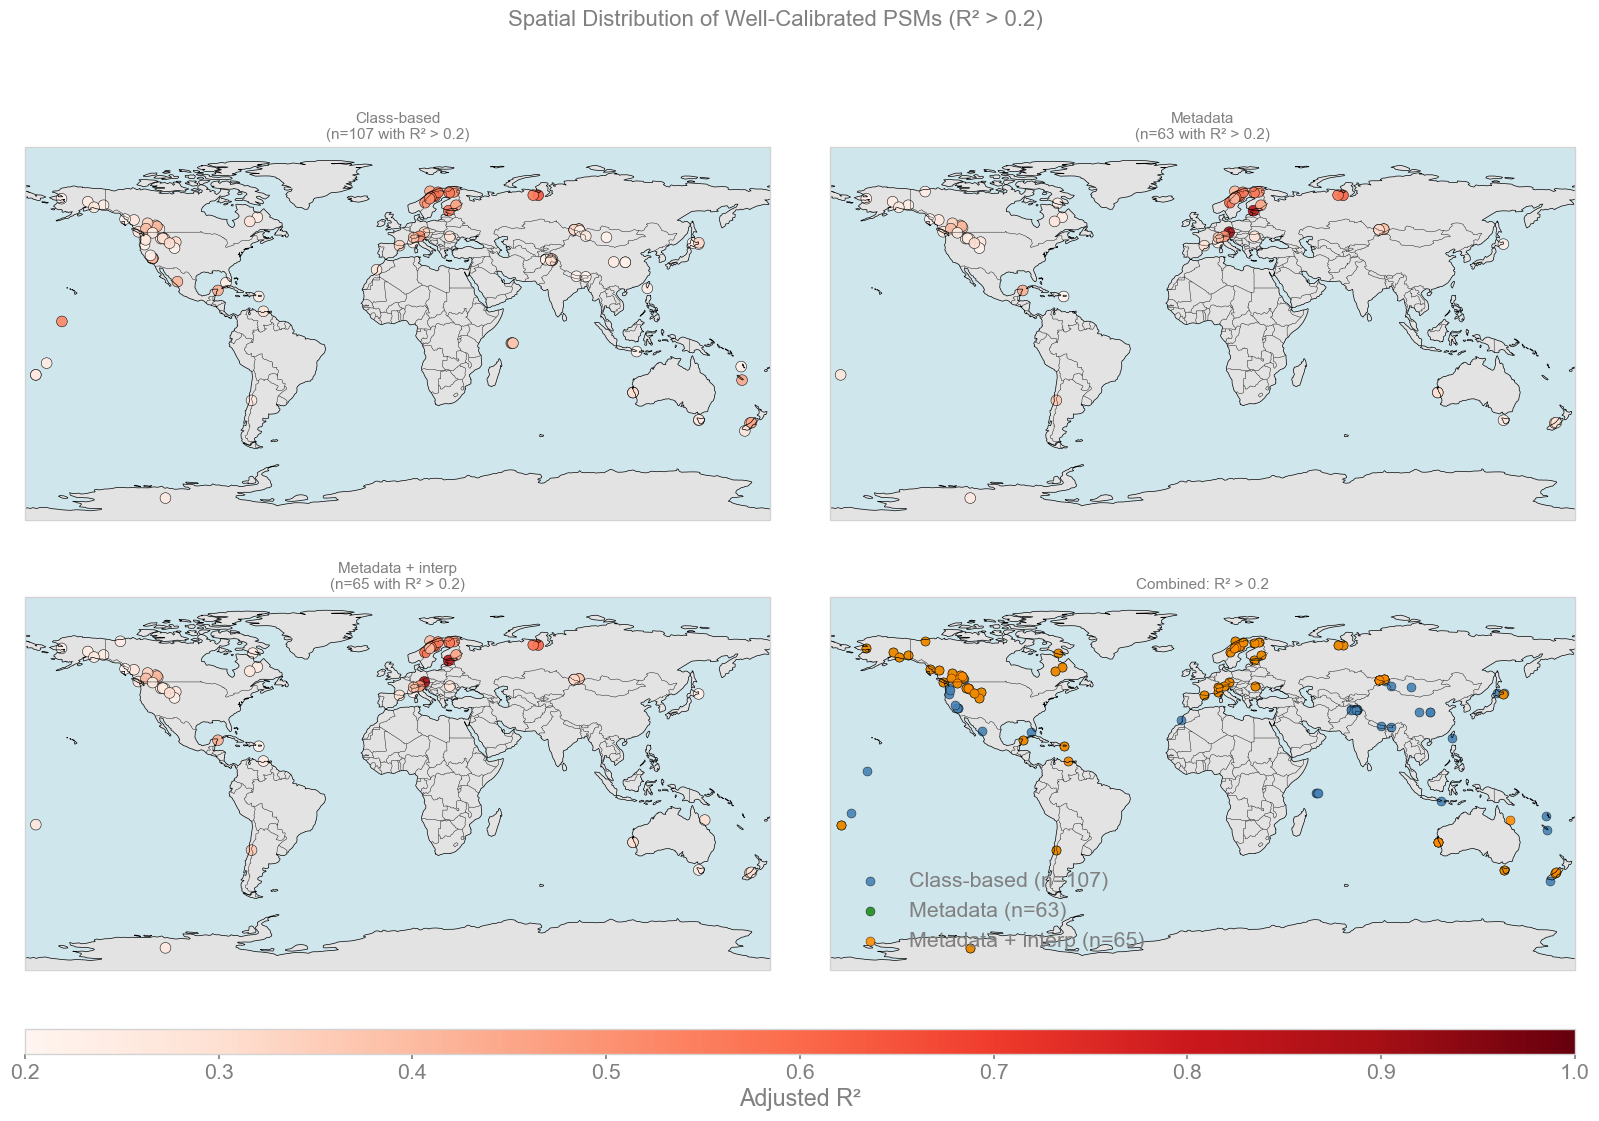

In [11]:
stats_class = extract_calib_stats_with_coords(job_class_new, "Class-based")
stats_meta  = extract_calib_stats_with_coords(job_meta, "Metadata")
stats_int   = extract_calib_stats_with_coords(job_meta_interp, "Metadata + interp")

plot_high_r2_spatial_comparison(stats_class, stats_meta, stats_int, r2_threshold=0.2)


### Key Takeaways

**Calibration distributions and table**:
- Class-based seasonality achieves the highest mean and median R^2 (~0.12 / 0.095), with more consistently skillful records.
- Metadata approaches have lower average skill (mean ~0.08 / median ~0.035), though they occasionally produce very high outliers 
- Interpolation increases record count but does not improve overall calibration quality, which could still contribute to the overall skill of the reconstruction.

**"Well-calibrated" records (R^2 > 0.2)**:
- Class-based has the largest number (n=107) compared to metadata (n=63) and metadata + interpolation (n=65).
- High-skill records are located mainly in Europe, North America, and parts of Asia (for class-based), with lower coverage in the tropics, oceans in general, and Southern Hemisphere.

**Overall**:
- Class-based calibration provides broader and more robust spatial coverage.
- Metadata-based adds a tiny number of high correlated sites (that require deeper investigation), but overall performance is worse and patchier 
- The combined view of all three shows that class-based is the strongest by default, with the metadata approach potentially contributing to some skill in very specific sites.
- It is important to note here that the network loses about 10% of its records once we whittle it down from class-based to metadata-based despite both starting from the same initial proxy database. Further investigations will show how much of an impact this has and if there are other combinations of databases (class-based with interp, etc.) that we can use to improve upon the baseline set by LMRv2.1.

## To-Do: Validation Against Withheld Proxies